In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from collections import defaultdict
from evaluation.evaluation_harness import OnlineEvaluator, include_coldstart, include_no_interactions, include_some_interactions, include_all, score_time_spent, score_constant
from statistical_test import estimate_probability_each_model_is_best
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.abspath(''), '../backend'))
from backend.blueprints.recommendation import model_wrappers

%load_ext autoreload
%autoreload 2

In [2]:
evaluator = OnlineEvaluator(include_all, score_constant)

In [3]:
current_models = []
for model_wrapper in model_wrappers:
    model_wrapper.model = model_wrapper.definition()
    model_wrapper.model.load(model_wrapper.model_save_file_name, load_published_model=True)
    current_models.append((model_wrapper.model.name(), model_wrapper.model_save_file_name))
evaluation_names = {'evaluation_test_random_model': 'random_model', 'evaluation_test_popularity_model': 'popularity_model', 'evaluation_test_common_neighbors_constant_scoring': 'common_neighbors_constant_scoring', 'evaluation_test_common_neighbors': 'common_neighbors_gaussian_scoring', 'evaluation_test_common_neighbors_percentile_scoring': 'common_neighbors_percentile_scoring', 'evaluation_test_cf_low_weight_decay_increased_lr_best_model_bugfix': 'collborative_filter', 'evaluation_test_gcf_low_weight_decay_increased_lr_best_model_bugfix': 'non_linear_collaborative_filter', 'evaluation_test_mlp_low_weight_decay_increased_lr_best_model_bugfix': 'multilayer_perceptron', 'evaluation_test_ncf_low_weight_decay_increased_lr_best_model_bugfix': 'neural_collaborative_filter', 'evaluation_test_cf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'collborative_filter_with_game_embeddings', 'evaluation_test_gcf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'non_linear_collaborative_filter_with_game_embeddings', 'evaluation_test_mlp_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'multilayer_perceptron_with_game_embeddings', 'evaluation_test_ncf_embed_all_except_tags_genres_best_model_bugfix_clip_embeddings': 'neural_collaborative_filter_with_game_embeddings'}

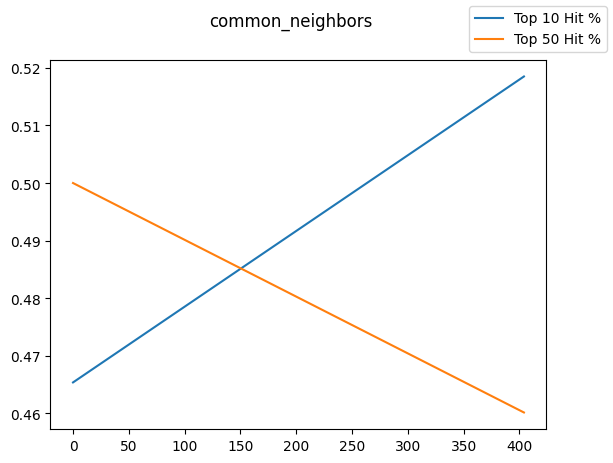

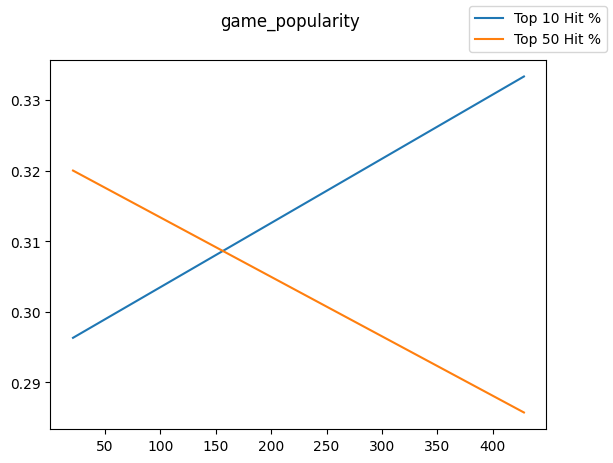

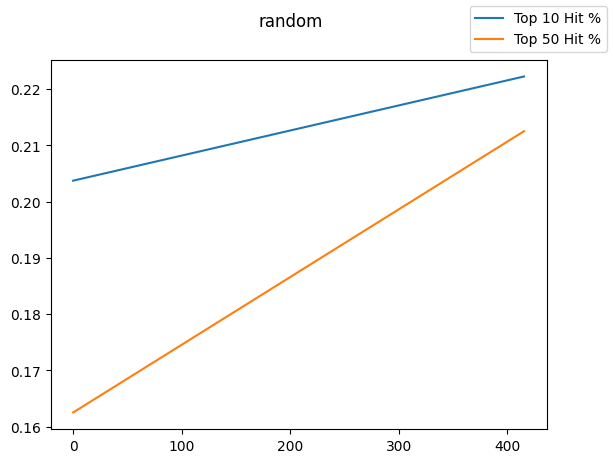

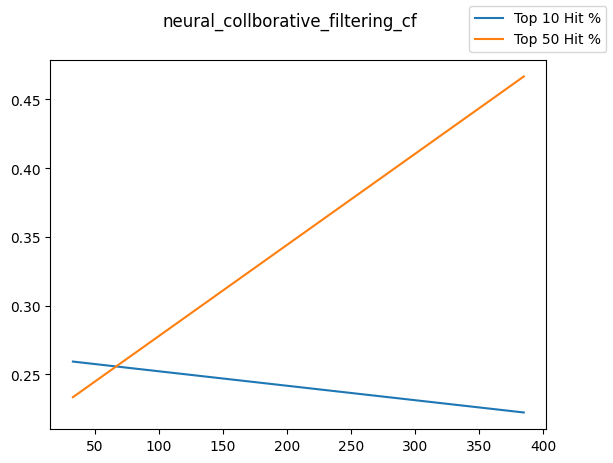

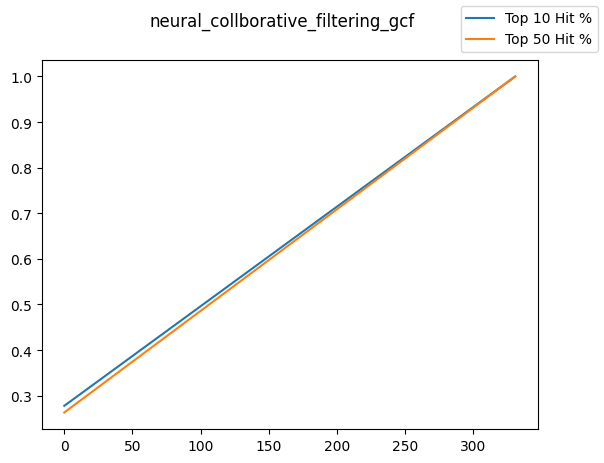

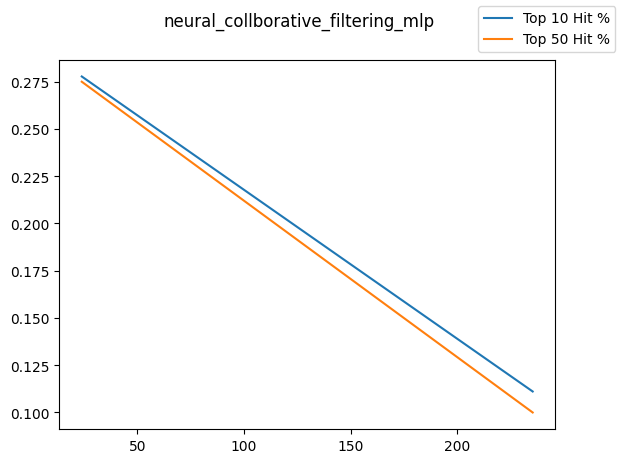

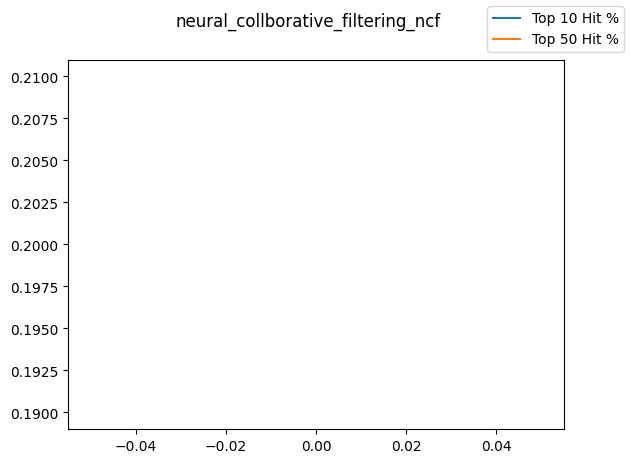

In [4]:
bucket_width = 5

cur_models_by_name = defaultdict(list)
for model_name, model_save_path in current_models:
    if model_save_path not in evaluation_names:
        continue
    cur_models_by_name[model_name].append(model_save_path)
for model_name, model_save_paths in cur_models_by_name.items():
    evaluator.reset(model_name, model_save_paths)
    num_interactions = evaluator.results_df["num_game_interactions_external"] + evaluator.results_df["num_game_interactions_local"]
    min_num = num_interactions.min()
    max_num = num_interactions.max()

    xs = []
    y_10s = []
    y_50s = []
    bucket_width = (max_num - min_num) / 3
    for start in [min_num, min_num + 2 * bucket_width]:
        evaluator.reset(model_name, model_save_paths, start, start + bucket_width)
        if evaluator.metrics["num_interactions"] == 0:
            continue
        evaluator.compute_top_N_hit_percentage(10)
        evaluator.compute_top_N_hit_percentage(50)
        xs.append(start)
        y_10s.append(evaluator.metrics["top_10_hit_percentage"])
        y_50s.append(evaluator.metrics["top_50_hit_percentage"])
    fig = plt.figure()
    fig.suptitle(model_name)
    ax = fig.add_subplot()
    ax.plot(xs, y_10s, label="Top 10 Hit %")
    ax.plot(xs, y_50s, label="Top 50 Hit %")
    fig.legend()

In [5]:
# groups = evaluator.all_results.groupby(by=["rec_model_name", "rec_model_save_path"])
# for (model_name, model_save_path), data in groups:
all_metrics = []
for model_name, model_save_path in current_models:
    evaluator.reset(model_name, model_save_path)
    # evaluator.plot_top_N_hit_percentage_percentiles(10)
    evaluator.compute_top_N_hit_percentage(10)
    # evaluator.plot_top_N_hit_percentage_percentiles(50)
    evaluator.compute_top_N_hit_percentage(50)
    # evaluator.plot_user_rank_roc_curve()
    evaluator.compute_user_rank_auc_roc()
    # evaluator.save_metrics('test_online_evaluator', overwrite=True)
    # pprint(evaluator.metrics)
    all_metrics.append({'model_name': model_name, 'model_save_path': model_save_path, **evaluator.metrics})
    # print()
results = pd.DataFrame(all_metrics)
estimate_probability_each_model_is_best(results, 'user_rank_auc_roc')
estimate_probability_each_model_is_best(results, 'top_10_hit_percentage')
estimate_probability_each_model_is_best(results, 'top_50_hit_percentage')

In [6]:
df = results.loc[results['model_save_path'].isin(evaluation_names), ['model_save_path', 'top_50_hit_percentage_best_probability', 'top_50_hit_percentage', 'top_50_hit_percentage_variance', 'num_interactions', 'top_10_hit_percentage_best_probability', 'top_10_hit_percentage', 'top_10_hit_percentage_variance', 'user_rank_auc_roc_best_probability', 'user_rank_auc_roc', 'user_rank_auc_roc_variance']].copy()
df['model_save_path'] = df['model_save_path'].map(evaluation_names)
display(df.sort_values(by='top_50_hit_percentage_best_probability', ascending=False))

,model_save_path,top_50_hit_percentage_best_probability,top_50_hit_percentage,top_50_hit_percentage_variance,num_interactions,top_10_hit_percentage_best_probability,top_10_hit_percentage,top_10_hit_percentage_variance,user_rank_auc_roc_best_probability,user_rank_auc_roc,user_rank_auc_roc_variance
1,common_neighbors_percentile_scoring,0.27904,0.561151,0.033549,200,0.08534,0.444444,0.025253,0.00199,0.570052,0.001682
2,common_neighbors_gaussian_scoring,0.27301,0.588710,0.012475,205,0.22237,0.555556,0.019048,0.00085,0.550212,0.001674
9,collborative_filter_with_game_embeddings,0.21938,0.400000,0.131034,30,0.28246,0.444444,0.162393,0.01585,0.527778,0.011794
12,neural_collaborative_filter_with_game_embeddings,0.12866,0.444444,0.041830,18,0.15754,0.470588,0.042484,0.09181,0.600000,0.019859
0,common_neighbors_constant_scoring,0.06348,0.453846,0.016537,167,0.15613,0.473684,0.039829,0.00006,0.485379,0.002065
5,collborative_filter,0.02310,0.383333,0.017232,60,0.01172,0.305556,0.021429,0.00004,0.386604,0.006066
10,non_linear_collaborative_filter_with_game_embe...,0.00566,0.333333,0.012580,33,0.02694,0.370370,0.019943,0.15225,0.673554,0.010363
4,random_model,0.00492,0.220238,0.026959,303,0.03169,0.269841,0.046083,0.00792,0.602320,0.001530
6,non_linear_collaborative_filter,0.00144,0.315789,0.008317,19,0.00698,0.333333,0.013072,0.04826,0.538462,0.022202
3,popularity_model,0.00124,0.339181,0.006253,224,0.01552,0.285714,0.028162,0.00000,0.478363,0.001613


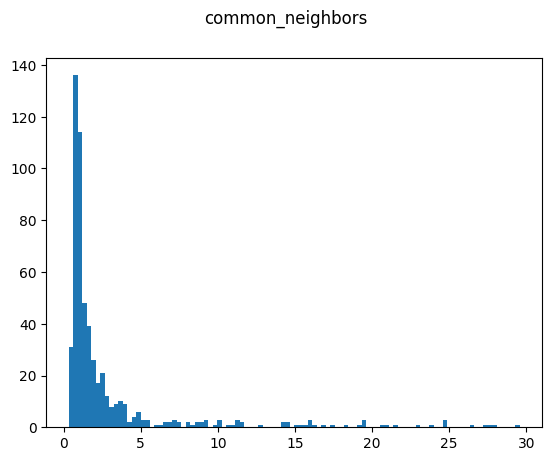

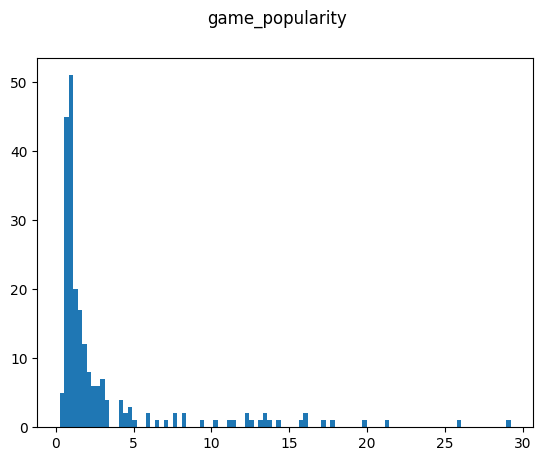

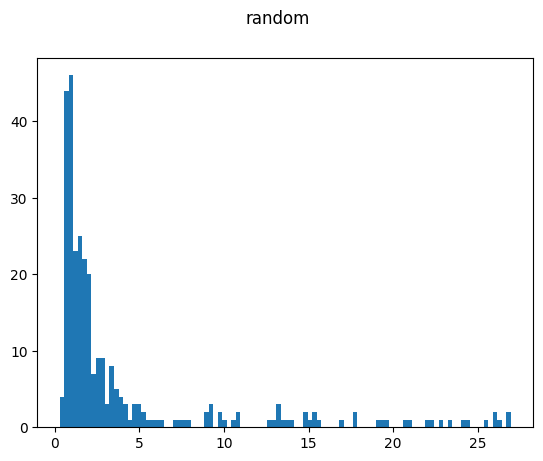

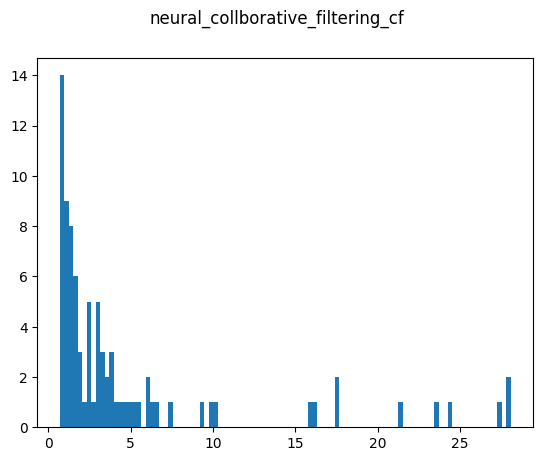

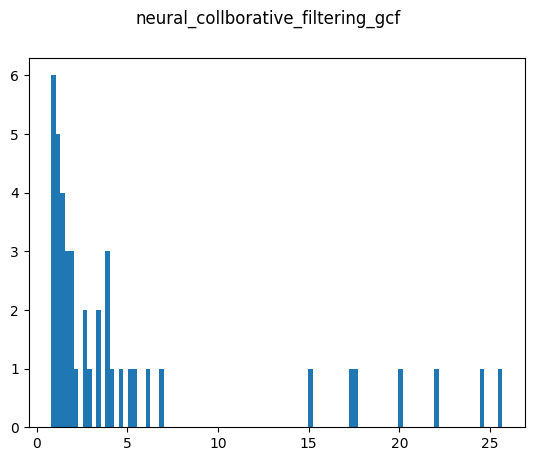

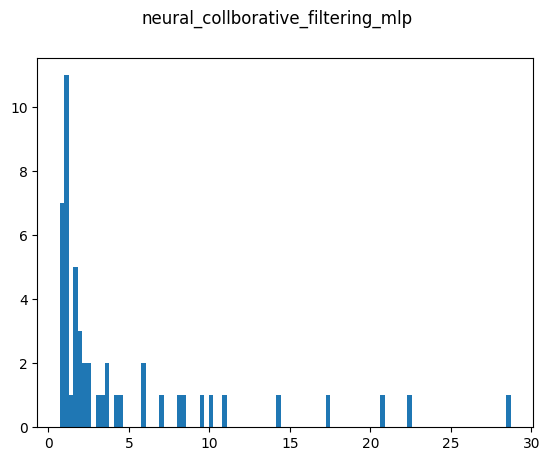

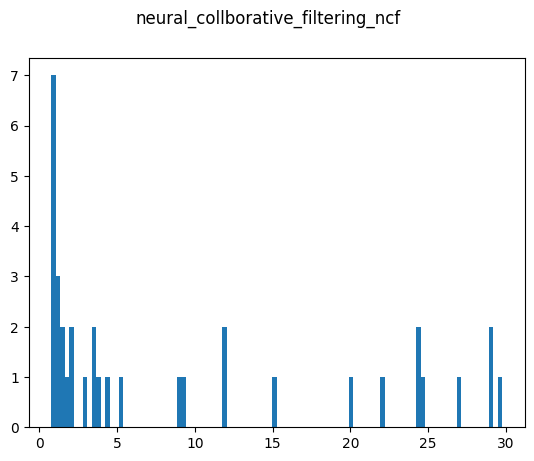

In [7]:

for model_name, model_save_paths in cur_models_by_name.items():
    evaluator.reset(model_name, model_save_paths)
    num_interactions = evaluator.results_df["num_game_interactions_external"] + evaluator.results_df["num_game_interactions_local"]
    min_num = num_interactions.min()
    max_num = num_interactions.max()

    xs = []
    y_10s = []
    y_50s = []
    bucket_width = (max_num - min_num) / 3
    evaluator.reset(model_name, model_save_paths)
    data = evaluator.results_df["time_spent"]
    data = data[data < 30]

    fig = plt.figure()
    fig.suptitle(model_name)
    ax = fig.add_subplot()
    ax.hist(data, bins=100)